# Datenvorbereitung_Regression
## Socken- (Schuh-) Daten in geeignetes Format bringen
... um trainierte Netzwerke mit geeigneten Daten zu "füttern".
Ersetzt die Schritte die in Matlab bereits für die Trainingsdaten ausgeführt wurden, unter Vernachlässigung der Bindungsdaten und derer Synchronisation.

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.axes as ax
import tensorflow as tf
import seaborn as sns
sns.set_style("whitegrid")
current_palette = sns.color_palette('colorblind')
#np.set_printoptions(threshold=np.inf) #um alle array einträge anzeigen zu lassen

## Sockendaten...

In [16]:
sock_data1 = pd.read_csv('Regression_Daten/socketest1.txt',delimiter='\t', header=0)
sock_data2 = pd.read_csv('Regression_Daten/socketest2.txt',delimiter='\t', header=0)
sock_data3 = pd.read_csv('Regression_Daten/socketest3.txt',delimiter='\t', header=0)
#sock_data
#sock_data.shape

In [17]:
sock_data1.shape, sock_data2.shape, sock_data3.shape

((899, 25), (662, 25), (8626, 25))

#### Berücksichtige nur Daten zwischen erstem und letztem Trigger:

In [18]:
#Finde Triggerpunkte
x = sock_data1.Trigger
trig=[]
get_indexes = lambda x, xs: [i for (y, i) in zip(xs, range(len(xs))) if x == y]
trig=get_indexes(1,x)
#Lösche Zeilen vor erstem und nach letztem Triggerpunkt
sock_data1=sock_data1.drop(sock_data1.index[range(max(trig)+1,len(sock_data1.index))])
sock_data1=sock_data1.drop(sock_data1.index[range(0,min(trig))])

x = sock_data2.Trigger
trig=[]
#Lösche Zeilen vor erstem und nach letztem Triggerpunkt
get_indexes = lambda x, xs: [i for (y, i) in zip(xs, range(len(xs))) if x == y]
trig=get_indexes(1,x)

sock_data2=sock_data2.drop(sock_data2.index[range(max(trig)+1,len(sock_data2.index))])
sock_data2=sock_data2.drop(sock_data2.index[range(0,min(trig))])

x = sock_data3.Trigger
trig=[]
#Lösche Zeilen vor erstem und nach letztem Triggerpunkt
get_indexes = lambda x, xs: [i for (y, i) in zip(xs, range(len(xs))) if x == y]
trig=get_indexes(1,x)

sock_data3=sock_data3.drop(sock_data3.index[range(max(trig)+1,len(sock_data3.index))])
sock_data3=sock_data3.drop(sock_data3.index[range(0,min(trig))])

In [19]:
#sock_data1.shape, sock_data2.shape, sock_data3.shape, 8626*2

#### Upsamling der Daten

In [20]:
sock_data1=sock_data1.rename(columns={"Milisec": "ms"})
sock_data1.ms = np.linspace(start=0,stop=(len(sock_data1)*100-100),num=len(sock_data1))#(sock_data.ms-sock_data.ms[min(trig)])
#Mache Indizes zu "TimedeltaIndizes" --> Vorraussetzung zum einfachen Resampeling
sock_data1.index = pd.TimedeltaIndex(sock_data1.ms,  unit='ms')
sock_data1 = sock_data1.drop(columns="Time") #Time ein tf-object das nicht mehr benötigt wird
sock_data1 = sock_data1.resample('50L').asfreq() #upsampling: '50L' entspricht 50ms
sock_data1 = sock_data1.interpolate(method='linear')
#sock_data1 = sock_data1[1:]

In [21]:
sock_data2=sock_data2.rename(columns={"Milisec": "ms"})
sock_data2.ms = np.linspace(start=0,stop=(len(sock_data2)*100-100),num=len(sock_data2))#(sock_data.ms-sock_data.ms[min(trig)])
#Mache Indizes zu "TimedeltaIndizes" --> Vorraussetzung zum einfachen Resampeling
sock_data2.index = pd.TimedeltaIndex(sock_data2.ms,  unit='ms')
sock_data2 = sock_data2.drop(columns="Time") #Time ein tf-object das nicht mehr benötigt wird
sock_data2 = sock_data2.resample('50L').asfreq() #upsampling: '50L' entspricht 50ms
sock_data2 = sock_data2.interpolate(method='linear')
sock_data2 = sock_data2[1:]

In [22]:
sock_data3=sock_data3.rename(columns={"Milisec": "ms"})
sock_data3.ms = np.linspace(start=0,stop=(len(sock_data3)*100-100),num=len(sock_data3))#(sock_data.ms-sock_data.ms[min(trig)])
#Mache Indizes zu "TimedeltaIndizes" --> Vorraussetzung zum einfachen Resampeling
sock_data3.index = pd.TimedeltaIndex(sock_data3.ms,  unit='ms')
sock_data3 = sock_data3.drop(columns="Time") #Time ein tf-object das nicht mehr benötigt wird
sock_data3 = sock_data3.resample('50L').asfreq() #upsampling: '50L' entspricht 50ms
sock_data3 = sock_data3.interpolate(method='linear')
sock_data3 = sock_data3[1:]

In [23]:
sock_data1.shape, sock_data2.shape, sock_data3.shape,

((1191, 24), (1018, 24), (16898, 24))

#### Daten für das Training der NNs vereinen

In [24]:
frames = [sock_data1, sock_data2, sock_data3]
sock_data = pd.concat(frames, axis=0)
#print(sock_data)

#### Setze den Millisekunden(ms)-Startwert des Dataframes (df) auf Null

In [25]:
sock_data=sock_data.rename(columns={"Milisec": "ms"})
sock_data.ms = np.linspace(start=0,stop=(len(sock_data)*50-50),num=len(sock_data))#(sock_data.ms-sock_data.ms[min(trig)])
#Mache Indizes zu "TimedeltaIndizes" --> Vorraussetzung zum einfachen Resampeling
sock_data.index = pd.TimedeltaIndex(sock_data.ms,  unit='ms')

In [1]:
#plt.plot(sock_data.index)

In [13]:
sock_data = sock_data.drop(['ms', 'M1A6', 'M2A6', 'Trigger'], axis=1) #Unnötige Spalten fallen lassen

In [14]:
#sock_data

#### Aufteilen der Daten in Trainings und in Testdaten:
    x_train    y_train                  60%
    x_val      y_val                    16%
    x_test     y_test                   24%

In [156]:
train = 0.60
val = 0.16
test = 0.24
idx_val = round(train*len(sock_data))
#idx_val = int(idx_val/batchsize)*batchsize
idx_test = round((train+val)*len(sock_data))
x_train_val = sock_data[:idx_test]
x_test0 = sock_data[idx_test:]

#### Normierung der Daten

In [158]:
mean = x_train_val.mean(axis=0)
x_train_val -= mean
std = x_train_val.std(axis=0)
x_train_val /= std

x_test0 -= mean #muss mit gleichen mean/std-Werten geschehen
x_test0 /= std #--"--

In [220]:
#np.save('NormData_mean',mean)
#np.save('NormData_std',std)

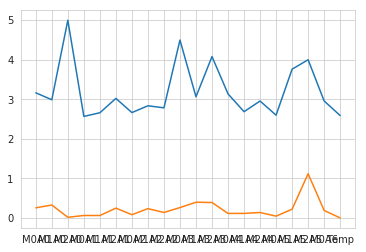

In [159]:
plt.figure()
plt.plot(mean)
plt.plot(std)
plt.show()

#### Teilen der Trainings- und Validierungsdaten

In [160]:
x_train0 = x_train_val[:idx_val]
x_val0 = x_train_val[idx_val:]

In [161]:
x_train0.shape, x_val0.shape, x_test0.shape

((11464, 20), (3057, 20), (4586, 20))

#### Reshaping...
... zu Format (samples, timesteps, features)

In [162]:
samples = None
timesteps = 22 #Auf 22 sek festgelegt (22*0.05s = 1.1s) ; ungleich 20 um von features.shape unterscheiden zu können 
features = len(x_train0.columns) #Anzahl der Sensoren
step = 1 #Versatz zum nächsten Sample; ungerade damit Interpolierte und urspüngliche Werte abwechselnd in die jeweilige LSTM-Zelle eingehen.
batchsize = 128

In [163]:
a = int(((len(x_train0))-timesteps)/step)
b = int(((len(x_val0))-timesteps)/step)
c = int(((len(x_test0))-timesteps)/step)

In [165]:
temp = np.ndarray((1,timesteps,features))
temp.fill(0)
x_train = np.ndarray((1,timesteps,features))
x_train.fill(0)

for i in range(a):
    for j in range(timesteps):
        for k in range(features):
            temp[0,j,k] = x_train0.iloc[(j+i*step),k]
    x_train = np.concatenate((x_train,temp), axis=0)
x_train = x_train[1:]

In [166]:
temp = np.ndarray((1,timesteps,features))
temp.fill(0)
x_val = np.ndarray((1,timesteps,features))
x_val.fill(0)

for i in range(b):
    for j in range(timesteps):
        for k in range(features):
            temp[0,j,k] = x_val0.iloc[(j+i*step),k]
    x_val = np.concatenate((x_val,temp), axis=0)
x_val = x_val[1:]

In [167]:
temp = np.ndarray((1,timesteps,features))
temp.fill(0)
x_test = np.ndarray((1,timesteps,features))
x_test.fill(0)

for i in range(c):
    for j in range(timesteps):
        for k in range(features):
            temp[0,j,k] = x_test0.iloc[(j+i*step),k]
    x_test = np.concatenate((x_test,temp), axis=0)
x_test = x_test[1:]           

In [168]:
x_train = x_train[:int(x_train.shape[0]/batchsize)*batchsize]

In [169]:
x_val = x_val[:int(x_val.shape[0]/batchsize)*batchsize]

In [170]:
x_test = x_test[:int(x_test.shape[0]/batchsize)*batchsize]

In [171]:
x_train.shape, x_val.shape, x_test.shape

((11392, 22, 20), (2944, 22, 20), (4480, 22, 20))

## Bindungsdaten

In [33]:
import scipy.io
from keras.utils import np_utils

Using TensorFlow backend.


In [34]:
#importiere gelabelte Kurvenfahrtendaten
mat1 = scipy.io.loadmat('Regression_Daten/y_Test1.mat')
mat2 = scipy.io.loadmat('Regression_Daten/y_Test2.mat')
mat3 = scipy.io.loadmat('Regression_Daten/y_Test3.mat')
y_mat1=mat1['y_Test1']
y_mat2=mat2['y_Test2']
y_mat3=mat3['y_Test3']
#yKurven.shape

#### betrachte nur Daten zwischen erstem und letztem Trigger

In [35]:
x=[]
trig=[]
x = y_mat1[:,3]
get_indexes = lambda x, xs: [i for (y, i) in zip(xs, range(len(xs))) if x <= y]
trig=get_indexes(4.5,x)
#Lösche Zeilen vor erstem und nach letztem Triggerpunkt
y_mat1=y_mat1[min(trig):max(trig),:]

x = y_mat2[:,3]
trig=[]
get_indexes = lambda x, xs: [i for (y, i) in zip(xs, range(len(xs))) if x <= y]
trig=get_indexes(4.5,x)
#Lösche Zeilen vor erstem und nach letztem Triggerpunkt
y_mat2=y_mat2[min(trig):max(trig),:]

x = y_mat3[:,3]
trig=[]
get_indexes = lambda x, xs: [i for (y, i) in zip(xs, range(len(xs))) if x <= y]
trig=get_indexes(4.5,x)
#Lösche Zeilen vor erstem und nach letztem Triggerpunkt
y_mat3=y_mat3[min(trig):max(trig),:]

In [36]:
y_mat = np.concatenate((y_mat1, y_mat2, y_mat3),axis=0)

In [37]:
y_mat1.shape, y_mat2.shape, y_mat3.shape, sock_data1.shape, sock_data2.shape, sock_data3.shape,

((1191, 4), (1018, 4), (16898, 4), (1191, 24), (1018, 24), (16898, 24))

Text(0.5, 0.04, 'Zeit [s]')

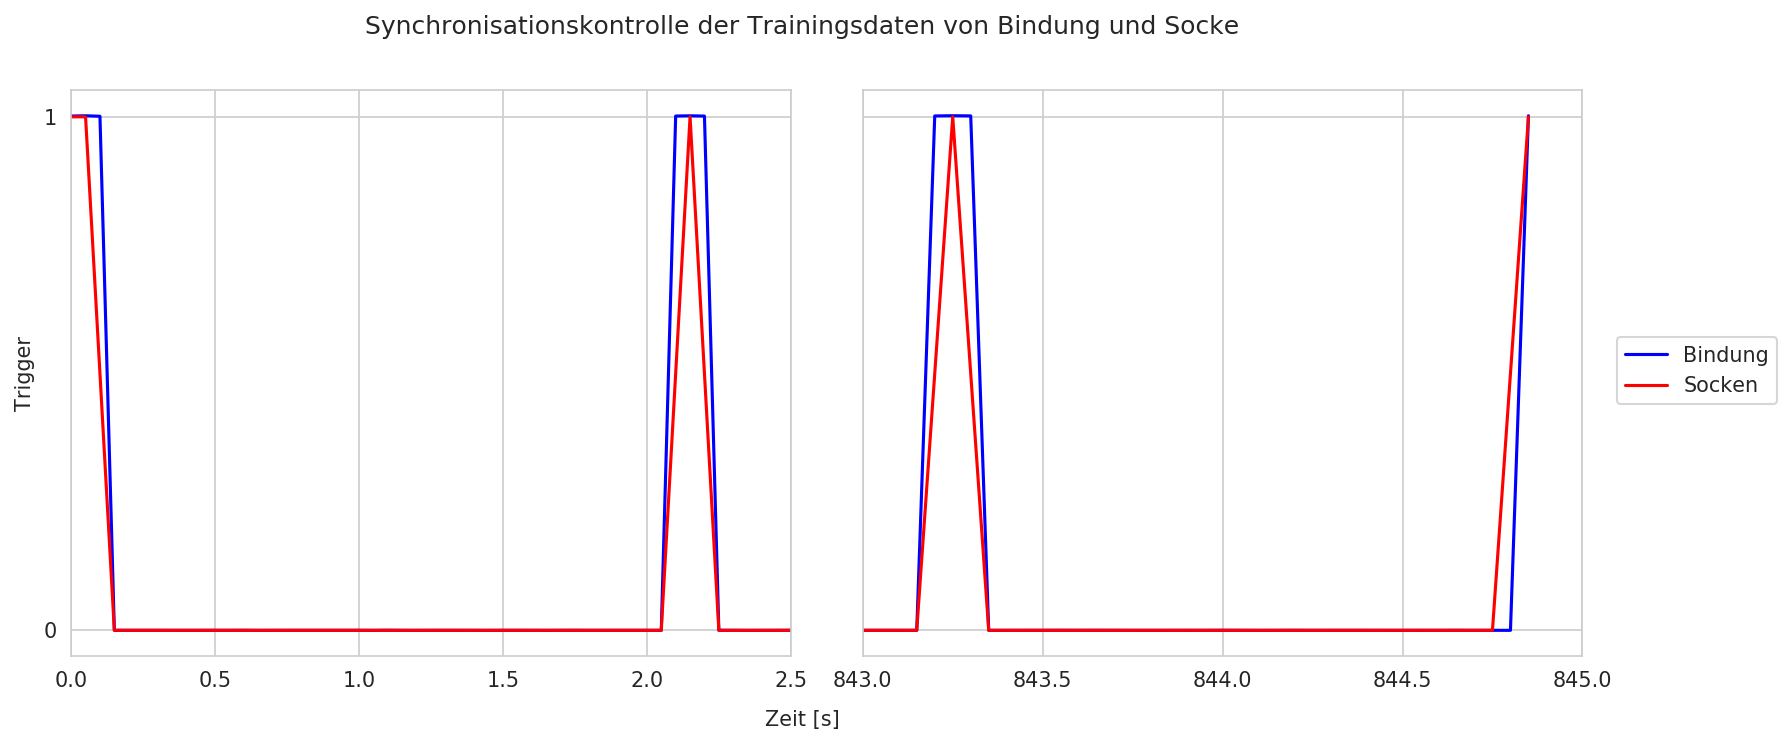

In [38]:
# Kontroll-Plot ob Triggerpunkte von Socken und Bindungsdaten übereinstimmen

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(13, 5), dpi=150, facecolor='w', edgecolor='k', sharey=True)
fig.suptitle('Synchronisationskontrolle der Trainingsdaten von Bindung und Socke')

ax1.plot(np.linspace(start=0,stop=len(y_mat3)-1,num=len(y_mat3))*0.05,y_mat3[:,3]/5,'b')
ax1.plot(np.linspace(start=0,stop=len(y_mat3)-1,num=len(y_mat3))*0.05,sock_data3.Trigger,'r')
ax1.set_xlim(0*0.05,50*0.05)
ax1.set(ylabel='Trigger', yticks=[0,1])
#fig.set_xlabel('Row Number of Data')

ax2.plot(np.linspace(start=0,stop=len(y_mat3)-1,num=len(y_mat3))*0.05,y_mat3[:,3]/5, 'b', label='Bindung')
ax2.plot(np.linspace(start=0,stop=len(y_mat3)-1,num=len(y_mat3))*0.05,sock_data3.Trigger, 'r', label='Socken')
ax2.set_xlim(16860*0.05,16900*0.05)
ax2.legend(bbox_to_anchor=(0.8, 0.1, 0.5, 0.5), borderaxespad=1)
fig.subplots_adjust(wspace=0.1)
ax2.set(xticks=[843,843.5,844,844.5,845])
fig.text(0.5, 0.04, 'Zeit [s]', ha='center', va='center')


#### Ausreißer der Fz-Daten beseitigen

Alle Werte außerhalb der 3sigma-Grenze beseitigen und linear interpolieren

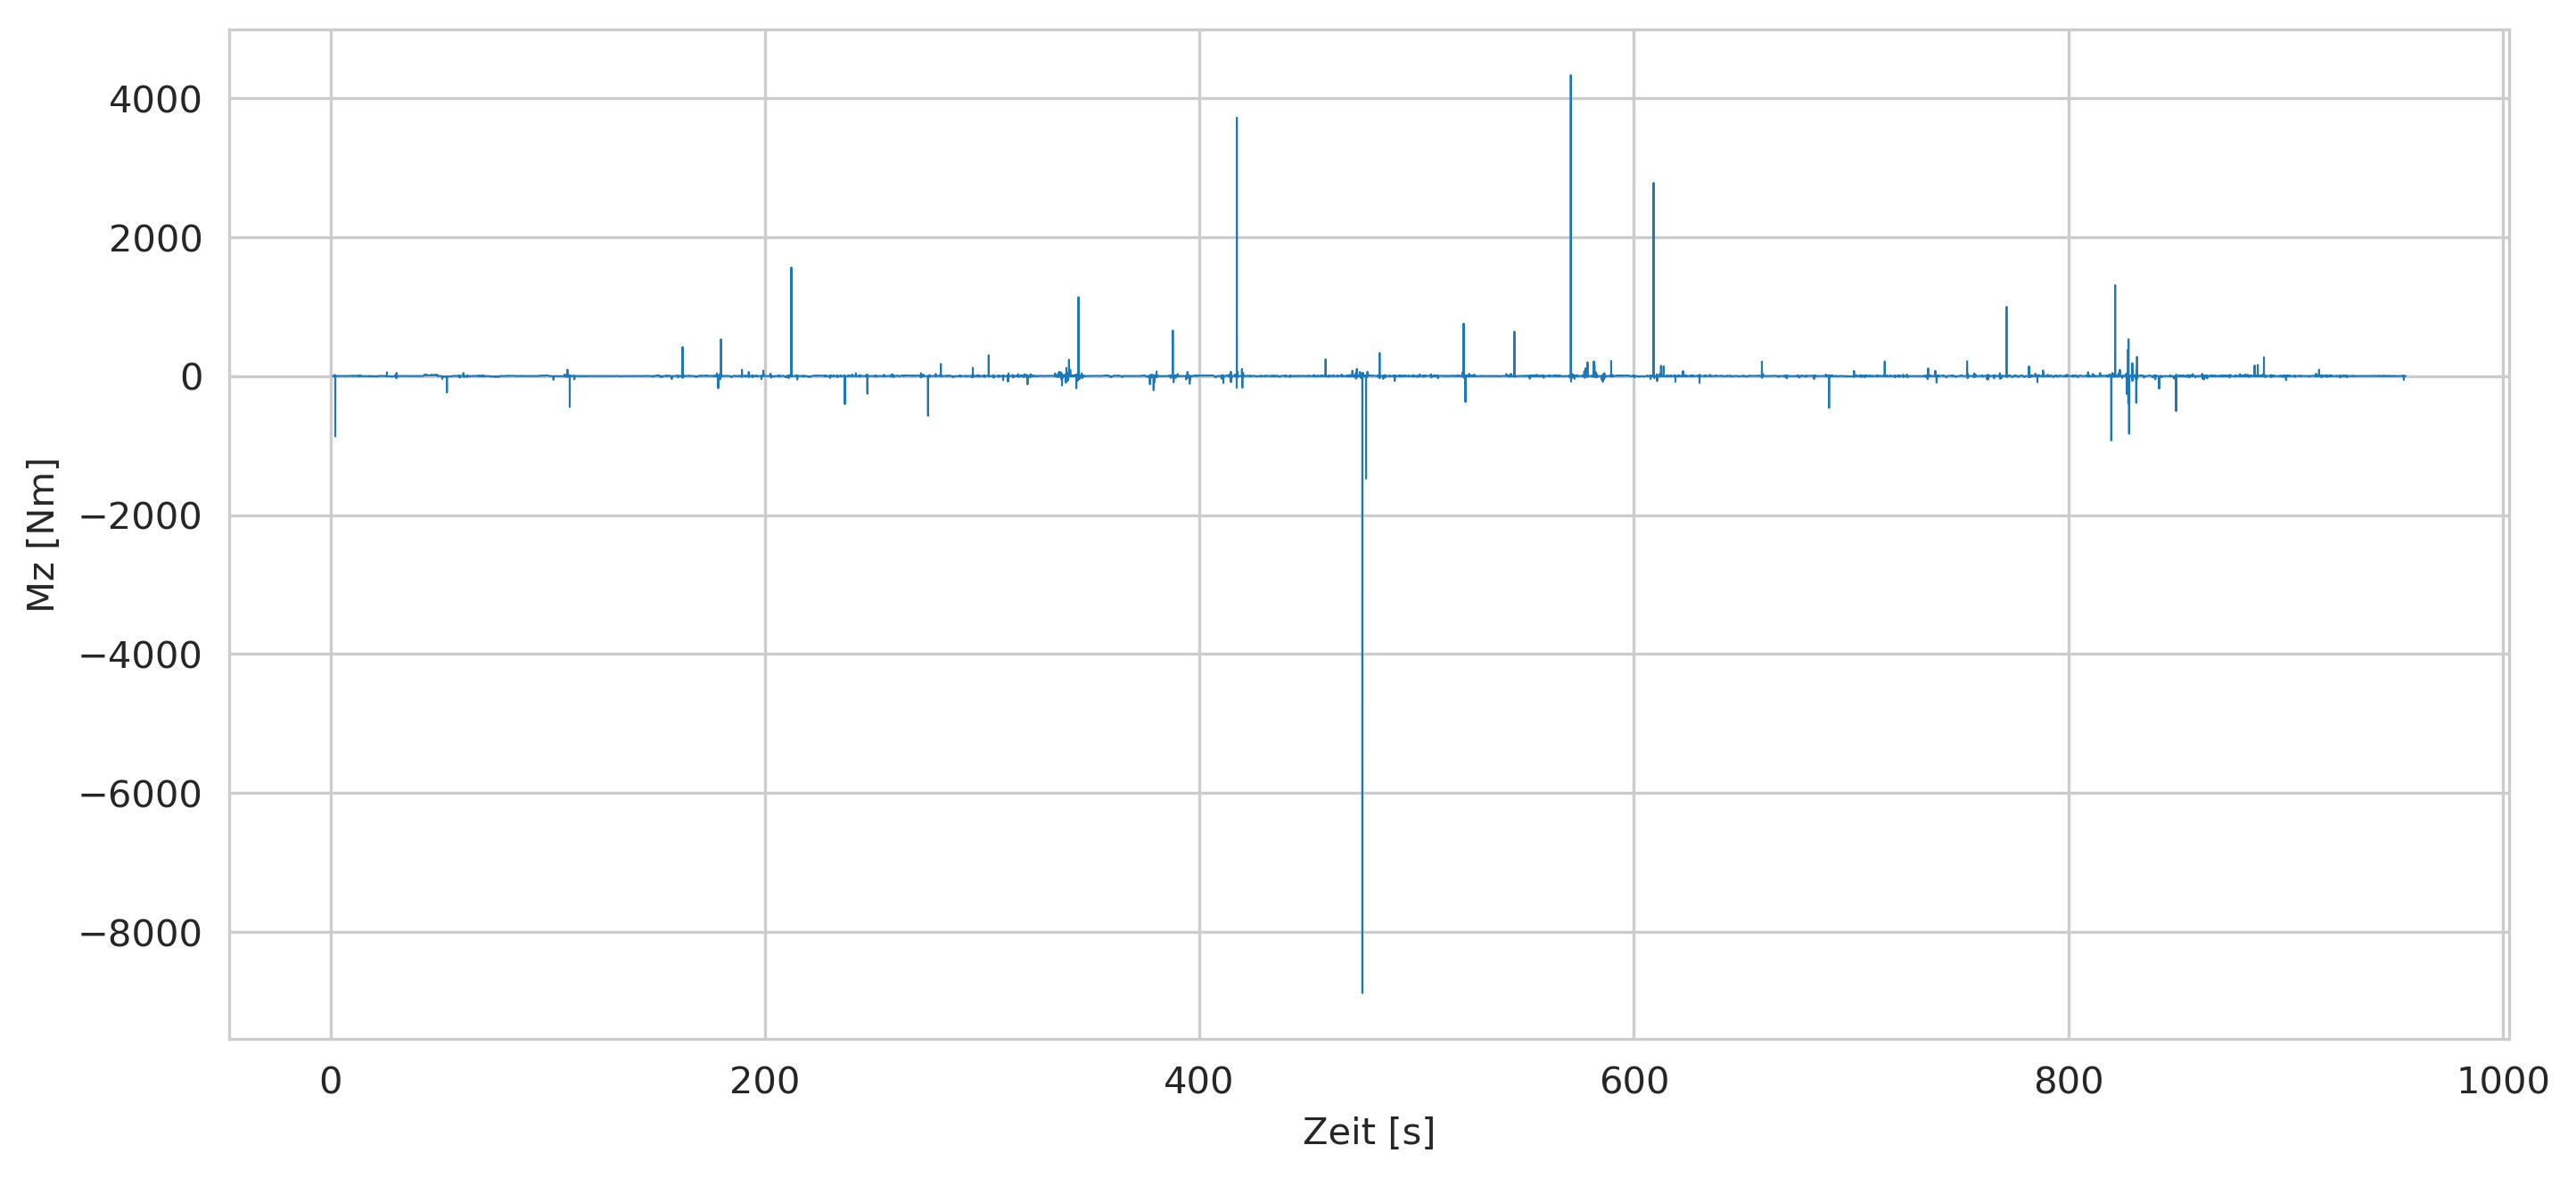

In [181]:
plt.figure(num=None, figsize=(11, 5), dpi=300, facecolor='w', edgecolor='k'),
plt.plot(np.linspace(1,len(y_mat)*0.05-0.05,len(y_mat)), y_mat[:,2], label='Mz',linewidth=0.5, mew=0.1)
plt.xlabel('Zeit [s]')
plt.ylabel('Mz [Nm]')
#plt.legend(bbox_to_anchor=(0.65, 0.15, 0.52, 0.4), borderaxespad=0)
#plt.xlim(left=600, right=800)
plt.show()

In [2]:
print(y_mat.shape)
plt.figure(num=None, figsize=(1, 6), dpi=50, facecolor='w', edgecolor='k'),
plt.ylabel('Mz [Nm]')
#plt.plot(np.linspace(start=0,stop=(len(y_mat3)-1),num=len(y_mat3))*0.05, y_mat3[:,2])
#plt.ylim(bottom=-10,top=10)
plt.ylim(bottom=-10, top=10)
sns.boxplot(data=y_mat[:,2])#, orient='horizontal')

NameError: name 'y_mat' is not defined

In [187]:
Fz_mean = np.mean(y_mat[:,2])
Fz_std = np.std(y_mat[:,2])
Fz_mean, Fz_std

(0.5375190907940057, 84.48314548417602)

In [188]:
Fz_lb = Fz_mean-3*Fz_std #untere Grenze (lower bound)
Fz_ub = Fz_mean+3*Fz_std #obere Grenze (upper bound)
Fz_lb, Fz_ub

(-252.91191736173406, 253.98695554332207)

In [41]:
#Ersetzen der Ausreißer/Fehlenden Werte mit Mean-Werten der Datenreihe 
#--> Methode beschrieben in "AN ANALYSIS OF FOUR MISSING DATA TREATMENT METHODS FOR SUPERVISED LEARNING"
y_mat_smooth = y_mat
for i in range(len(y_mat_smooth[:,2])):
    if y_mat_smooth[i,2] > Fz_ub:
        y_mat_smooth[i,2]=Fz_mean
    elif y_mat_smooth[i,2] < Fz_lb:
        y_mat_smooth[i,2]=Fz_mean
    else:
        y_mat_smooth[i,2]=y_mat_smooth[i,2]

NameError: name 'Fz_ub' is not defined





Aufteilen der Daten in Trainings und in Testdaten:

    x_train    y_train                  60%
    x_val      y_val                    16%
    x_test     y_test                   24%

In [190]:
x_train.shape, x_val.shape, x_test.shape

((11392, 22, 20), (2944, 22, 20), (4480, 22, 20))

In [191]:
 idx_val, idx_test, a, b, c

(11464, 14521, 11442, 3035, 4564)

In [192]:
y_all_train_val = y_mat_smooth[:idx_test]
y_all_train0 = y_mat_smooth[:idx_val]
y_all_val0 = y_mat_smooth[idx_val:]
y_all_test0 = y_mat_smooth[idx_test:]
#y_all_test0.shape

In [197]:
#plt.plot(y_mat_smooth[:,2])

#### Y: Bindungsdaten für Trainingsshape (None,Timesteps,1)

verwendundung dieses Formats bei letzter LSTM-Layer-Einstellung: return_sequence=True

In [198]:
#Fz in shape=(None,timesteps,1)
    #train
temp = np.ndarray((1,timesteps,1))
temp.fill(0)
y_Fz_train1 = np.ndarray((1,timesteps,1))
y_Fz_train1.fill(0)

for i in range(a):
    for j in range(timesteps):
        temp[0,j,0] = y_all_train0[(j+i*step),0] #0 für Fz (1.Spalte)
    y_Fz_train1 = np.concatenate((y_Fz_train1,temp), axis=0)
y_Fz_train1 = y_Fz_train1[1:]
   
    #val
temp.fill(0)
y_Fz_val1 = np.ndarray((1,timesteps,1))
y_Fz_val1.fill(0)

for i in range(b):
    for j in range(timesteps):
        temp[0,j,0] = y_all_val0[(j+i*step),0] #0 für Fz (1.Spalte)
    y_Fz_val1 = np.concatenate((y_Fz_val1,temp), axis=0)
y_Fz_val1 = y_Fz_val1[1:]
  
    #test
temp.fill(0)
y_Fz_test1 = np.ndarray((1,timesteps,1))
y_Fz_test1.fill(0)

for i in range(c):
    for j in range(timesteps):
        temp[0,j,0] = y_all_test0[(j+i*step),0] #0 für Fz (1.Spalte)
    y_Fz_test1 = np.concatenate((y_Fz_test1,temp), axis=0)
y_Fz_test1 = y_Fz_test1[1:]

y_Fz_train1 = y_Fz_train1[:(int(y_Fz_train1.shape[0]/batchsize)*batchsize)]
y_Fz_val1 = y_Fz_val1[:(int(y_Fz_val1.shape[0]/batchsize)*batchsize)]
y_Fz_test1 = y_Fz_test1[:(int(y_Fz_test1.shape[0]/batchsize)*batchsize)]

In [199]:
#My in shape=(None,timesteps,1)
    #train
temp = np.ndarray((1,timesteps,1))
temp.fill(0)
y_My_train1 = np.ndarray((1,timesteps,1))
y_My_train1.fill(0)

for i in range(a):
    for j in range(timesteps):
        temp[0,j,0] = y_all_train0[(j+i*step),1] #1 für My (2.Spalte)
    y_My_train1 = np.concatenate((y_My_train1,temp), axis=0)
y_My_train1 = y_My_train1[1:]
   
    #val
temp.fill(0)
y_My_val1 = np.ndarray((1,timesteps,1))
y_My_val1.fill(0)

for i in range(b):
    for j in range(timesteps):
        temp[0,j,0] = y_all_val0[(j+i*step),1] #1 für My (2.Spalte)
    y_My_val1 = np.concatenate((y_My_val1,temp), axis=0)
y_My_val1 = y_My_val1[1:]
  
    #test
temp.fill(0)
y_My_test1 = np.ndarray((1,timesteps,1))
y_My_test1.fill(0)

for i in range(c):
    for j in range(timesteps):
        temp[0,j,0] = y_all_test0[(j+i*step),1] #1 für My (2.Spalte)
    y_My_test1 = np.concatenate((y_My_test1,temp), axis=0)
y_My_test1 = y_My_test1[1:]

y_My_train1 = y_My_train1[:(int(y_My_train1.shape[0]/batchsize)*batchsize)]
y_My_val1 = y_My_val1[:(int(y_My_val1.shape[0]/batchsize)*batchsize)]
y_My_test1 = y_My_test1[:(int(y_My_test1.shape[0]/batchsize)*batchsize)]

In [200]:
#My in shape=(None,timesteps,1)
    #train
temp = np.ndarray((1,timesteps,1))
temp.fill(0)
y_Mz_train1 = np.ndarray((1,timesteps,1))
y_Mz_train1.fill(0)

for i in range(a):
    for j in range(timesteps):
        temp[0,j,0] = y_all_train0[(j+i*step),2] #2 für Mz (3.Spalte)
    y_Mz_train1 = np.concatenate((y_Mz_train1,temp), axis=0)
y_Mz_train1 = y_Mz_train1[1:]
   
    #val
temp.fill(0)
y_Mz_val1 = np.ndarray((1,timesteps,1))
y_Mz_val1.fill(0)

for i in range(b):
    for j in range(timesteps):
        temp[0,j,0] = y_all_val0[(j+i*step),2] #2 für Mz (3.Spalte)
    y_Mz_val1 = np.concatenate((y_Mz_val1,temp), axis=0)
y_Mz_val1 = y_Mz_val1[1:]
  
    #test
temp.fill(0)
y_Mz_test1 = np.ndarray((1,timesteps,1))
y_Mz_test1.fill(0)

for i in range(c):
    for j in range(timesteps):
        temp[0,j,0] = y_all_test0[(j+i*step),2] #2 für Mz (3.Spalte)
    y_Mz_test1 = np.concatenate((y_Mz_test1,temp), axis=0)
y_Mz_test1 = y_Mz_test1[1:]

y_Mz_train1 = y_Mz_train1[:(int(y_Mz_train1.shape[0]/batchsize)*batchsize)]
y_Mz_val1 = y_Mz_val1[:(int(y_Mz_val1.shape[0]/batchsize)*batchsize)]
y_Mz_test1 = y_Mz_test1[:(int(y_Mz_test1.shape[0]/batchsize)*batchsize)]

#### Y: Bindungsdaten für Trainingsshape (None,1)

verwendundung dieses Formats bei letzter LSTM-Layer-Einstellung: return_sequence=False

In [201]:
#Fz in shape=(None,1)
    #train
temp = np.ndarray((1,1))
temp.fill(0)
y_Fz_train2 = np.ndarray((1,1))
y_Fz_train2.fill(0)

for i in range(a):
    temp[0] = y_all_train0[(i*step+timesteps-1),0] #0 für Fz (1.Spalte) +timesteps um ein Sample mit dem Endwert des korrelierenden Fz-Werts zu trainieren
    y_Fz_train2 = np.concatenate((y_Fz_train2,temp), axis=0)
y_Fz_train2 = y_Fz_train2[1:]
   
    #val
temp.fill(0)
y_Fz_val2 = np.ndarray((1,1))
y_Fz_val2.fill(0)

for i in range(b):
    temp[0] = y_all_val0[(i*step+timesteps-1),0] #0 für Fz (1.Spalte)
    y_Fz_val2 = np.concatenate((y_Fz_val2,temp), axis=0)
y_Fz_val2 = y_Fz_val2[1:]
  
    #test
temp.fill(0)
y_Fz_test2 = np.ndarray((1,1))
y_Fz_test2.fill(0)

for i in range(c):
    temp[0] = y_all_test0[(i*step+timesteps-1),0] #0 für Fz (1.Spalte)
    y_Fz_test2 = np.concatenate((y_Fz_test2,temp), axis=0)
y_Fz_test2 = y_Fz_test2[1:]

y_Fz_train2 = y_Fz_train2[:(int(y_Fz_train2.shape[0]/batchsize)*batchsize)]
y_Fz_val2 = y_Fz_val2[:(int(y_Fz_val2.shape[0]/batchsize)*batchsize)]
y_Fz_test2 = y_Fz_test2[:(int(y_Fz_test2.shape[0]/batchsize)*batchsize)]

In [202]:
#My in shape=(None,1)
    #train
temp = np.ndarray((1,1))
temp.fill(0)
y_My_train2 = np.ndarray((1,1))
y_My_train2.fill(0)

for i in range(a):
    temp[0] = y_all_train0[(i*step+timesteps-1),1] #1 für My (2.Spalte) +timesteps um ein Sample mit dem Endwert des korrelierenden My-Werts zu trainieren
    y_My_train2 = np.concatenate((y_My_train2,temp), axis=0)
y_My_train2 = y_My_train2[1:]
   
    #val
temp.fill(0)
y_My_val2 = np.ndarray((1,1))
y_My_val2.fill(0)

for i in range(b):
    temp[0] = y_all_val0[(i*step+timesteps-1),1] #1 für My (2.Spalte)
    y_My_val2 = np.concatenate((y_My_val2,temp), axis=0)
y_My_val2 = y_My_val2[1:]
  
    #test
temp.fill(0)
y_My_test2 = np.ndarray((1,1))
y_My_test2.fill(0)

for i in range(c):
    temp[0] = y_all_test0[(i*step+timesteps-1),1] #1 für My (2.Spalte)
    y_My_test2 = np.concatenate((y_My_test2,temp), axis=0)
y_My_test2 = y_My_test2[1:]

y_My_train2 = y_My_train2[:(int(y_My_train2.shape[0]/batchsize)*batchsize)]
y_My_val2 = y_My_val2[:(int(y_My_val2.shape[0]/batchsize)*batchsize)]
y_My_test2 = y_My_test2[:(int(y_My_test2.shape[0]/batchsize)*batchsize)]

In [203]:
#Mz in shape=(None,1)
    #train
temp = np.ndarray((1,1))
temp.fill(0)
y_Mz_train2 = np.ndarray((1,1))
y_Mz_train2.fill(0)

for i in range(a):
    temp[0] = y_all_train0[(i*step+timesteps-1),2] #2 für Mz (3.Spalte) +timesteps um ein Sample mit dem Endwert des korrelierenden Mz-Werts zu trainieren
    y_Mz_train2 = np.concatenate((y_Mz_train2,temp), axis=0)
y_Mz_train2 = y_Mz_train2[1:]
   
    #val
temp.fill(0)
y_Mz_val2 = np.ndarray((1,1))
y_Mz_val2.fill(0)

for i in range(b):
    temp[0] = y_all_val0[(i*step+timesteps-1),2] #2 für Mz (3.Spalte)
    y_Mz_val2 = np.concatenate((y_Mz_val2,temp), axis=0)
y_Mz_val2 = y_Mz_val2[1:]
  
    #test
temp.fill(0)
y_Mz_test2 = np.ndarray((1,1))
y_Mz_test2.fill(0)

for i in range(c):
    temp[0] = y_all_test0[(i*step+timesteps-1),2] #2 für Mz (3.Spalte)
    y_Mz_test2 = np.concatenate((y_Mz_test2,temp), axis=0)
y_Mz_test2 = y_Mz_test2[1:]

y_Mz_train2 = y_Mz_train2[:(int(y_Mz_train2.shape[0]/batchsize)*batchsize)]
y_Mz_val2 = y_Mz_val2[:(int(y_Mz_val2.shape[0]/batchsize)*batchsize)]
y_Mz_test2 = y_Mz_test2[:(int(y_Mz_test2.shape[0]/batchsize)*batchsize)]

In [207]:
a, b, c

(11442, 3035, 4564)

In [208]:
x_train.shape[0], x_val.shape[0], x_test.shape[0]

(11392, 2944, 4480)

In [209]:
# Kontrolle länge Trainingsdaten
y_Fz_train1.shape[0], y_Fz_train2.shape[0], y_My_train1.shape[0], y_My_train2.shape[0], y_Mz_train1.shape[0], y_Mz_train2.shape[0],#, y_k_val.shape, y_k_test.shape, a, b, c, idx_val, idx_test

(11392, 11392, 11392, 11392, 11392, 11392)

In [210]:
# Kontrolle länge Validierungsdaten
y_Fz_val1.shape[0], y_Fz_val2.shape[0], y_My_val1.shape[0], y_My_val2.shape[0], y_Mz_val1.shape[0], y_Mz_val2.shape[0]

(2944, 2944, 2944, 2944, 2944, 2944)

In [211]:
# Kontrolle länge Testdaten
y_Fz_test1.shape[0], y_Fz_test2.shape[0], y_My_test1.shape[0], y_My_test2.shape[0], y_Mz_test1.shape[0], y_Mz_test2.shape[0]

(4480, 4480, 4480, 4480, 4480, 4480)

#### Abspeichern der Trainings- Validierungs- und Testdaten der Eingabe x und Ausgabe y

In [217]:
np.save('Regression_Daten/x_train', x_train)
np.save('Regression_Daten/x_val', x_val)
np.save('Regression_Daten/x_test', x_test)

np.save('Regression_Daten/y_Fz_train1', y_Fz_train1)
np.save('Regression_Daten/y_Fz_val1', y_Fz_val1)
np.save('Regression_Daten/y_Fz_test1', y_Fz_test1)

np.save('Regression_Daten/y_My_train1', y_My_train1)
np.save('Regression_Daten/y_My_val1', y_My_val1)
np.save('Regression_Daten/y_My_test1', y_My_test1)

np.save('Regression_Daten/y_Mz_train1', y_Mz_train1)
np.save('Regression_Daten/y_Mz_val1', y_Mz_val1)
np.save('Regression_Daten/y_Mz_test1', y_Mz_test1)

np.save('Regression_Daten/y_Fz_train2', y_Fz_train2)
np.save('Regression_Daten/y_Fz_val2', y_Fz_val2)
np.save('Regression_Daten/y_Fz_test2', y_Fz_test2)

np.save('Regression_Daten/y_My_train2', y_My_train2)
np.save('Regression_Daten/y_My_val2', y_My_val2)
np.save('Regression_Daten/y_My_test2', y_My_test2)

np.save('Regression_Daten/y_Mz_train2', y_Mz_train2)
np.save('Regression_Daten/y_Mz_val2', y_Mz_val2)
np.save('Regression_Daten/y_Mz_test2', y_Mz_test2)

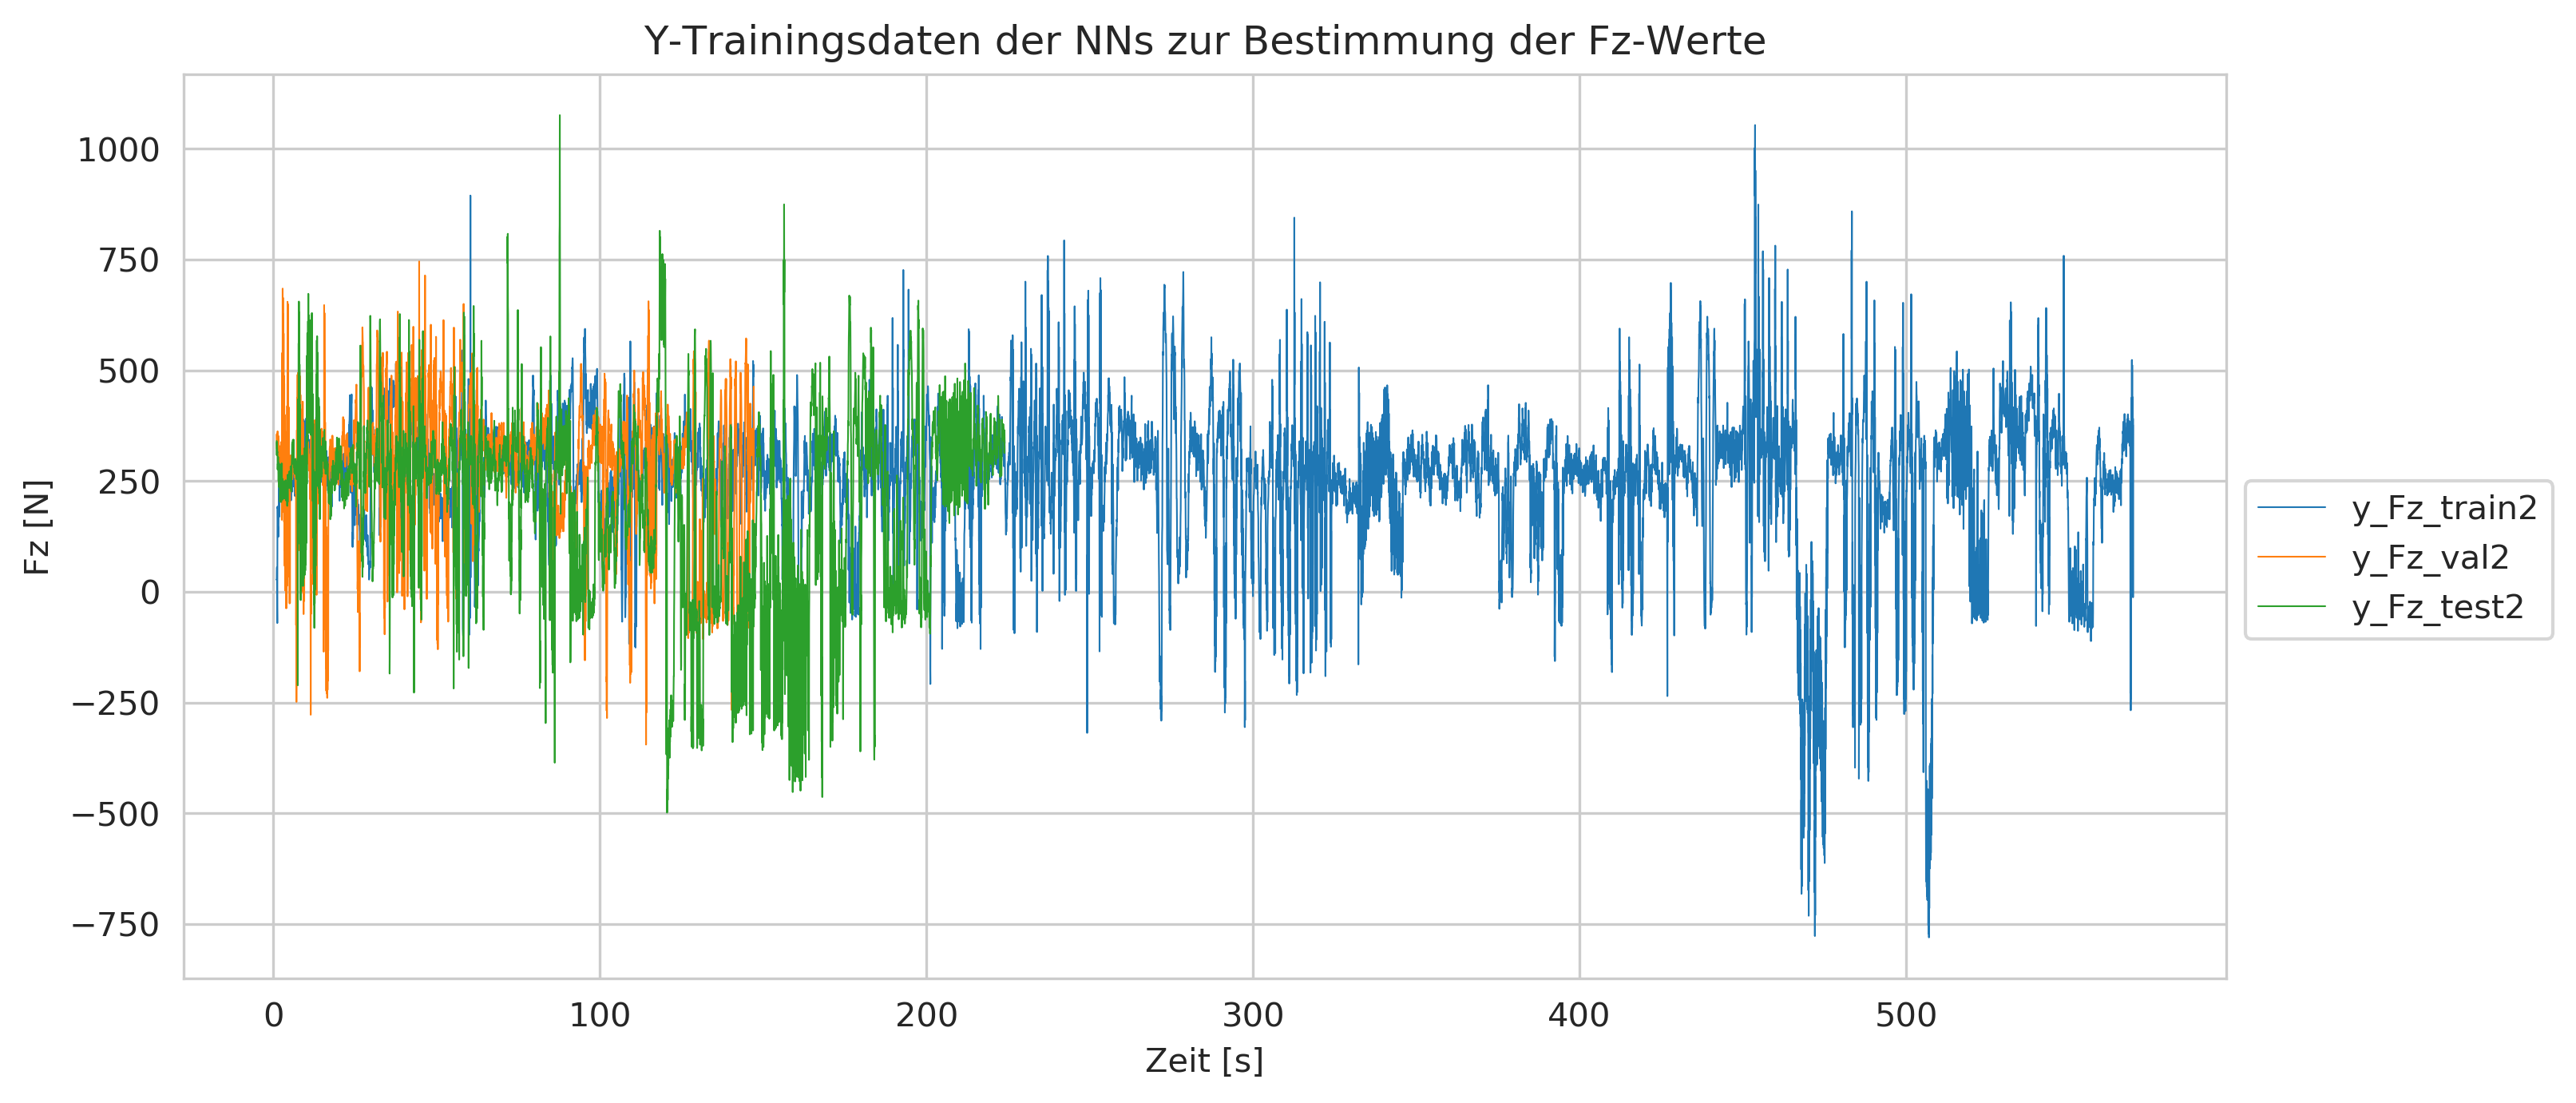

In [238]:
plt.figure(num=None, figsize=(11, 5), dpi=300, facecolor='w', edgecolor='k'),

#plt.yticks([0,1,2,3])

plt.plot(np.linspace(1,len(y_Fz_train2)*0.05-0.05,len(y_Fz_train2)), y_Fz_train2, label='y_Fz_train2',linewidth=0.5, mew=0.1)
plt.plot(np.linspace(1,len(y_Fz_val2)*0.05-0.05,len(y_Fz_val2)), y_Fz_val2, label='y_Fz_val2',linewidth=0.5, mew=0.1)
plt.plot(np.linspace(1,len(y_Fz_test2)*0.05-0.05,len(y_Fz_test2)), y_Fz_test2, label='y_Fz_test2',linewidth=0.5, mew=0.1)

plt.title('Y-Trainingsdaten der NNs zur Bestimmung der Fz-Werte')
plt.xlabel('Zeit [s]')
plt.ylabel('Fz [N]')

plt.legend(bbox_to_anchor=(0.64, 0.15, 0.52, 0.4), borderaxespad=0)
#plt.xlim(left=600, right=800)

plt.show()

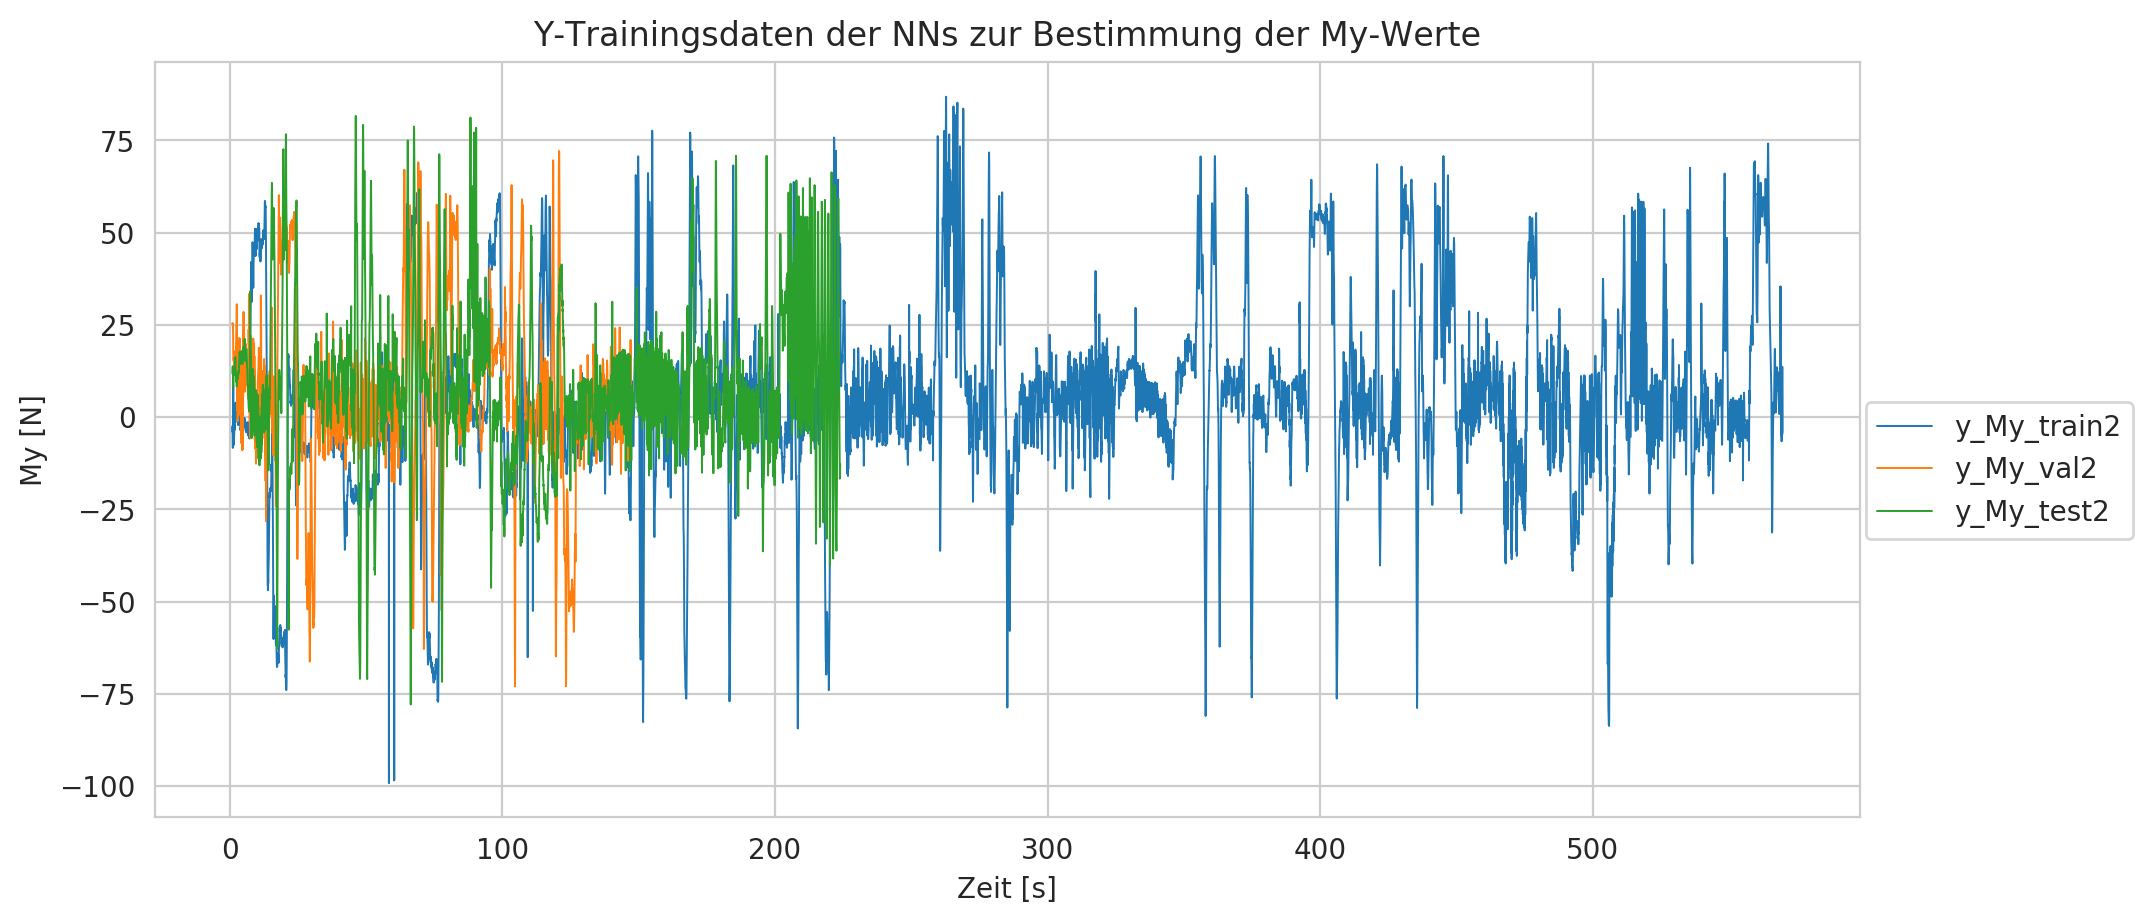

In [236]:
plt.figure(num=None, figsize=(11, 5), dpi=200, facecolor='w', edgecolor='k'),

#plt.yticks([0,1,2,3])
plt.plot(np.linspace(1,len(y_My_train2)*0.05-0.05,len(y_My_train2)), y_My_train2, label='y_My_train2',linewidth=0.7, mew=0.1)
plt.plot(np.linspace(1,len(y_My_val2)*0.05-0.05,len(y_My_val2)), y_My_val2, label='y_My_val2',linewidth=0.7, mew=0.1)
plt.plot(np.linspace(1,len(y_My_test2)*0.05-0.05,len(y_My_test2)), y_My_test2, label='y_My_test2',linewidth=0.7, mew=0.1)

plt.title('Y-Trainingsdaten der NNs zur Bestimmung der My-Werte')
plt.xlabel('Zeit [s]')
plt.ylabel('My [N]')

plt.legend(bbox_to_anchor=(0.64, 0.15, 0.52, 0.4), borderaxespad=0)
#plt.xlim(left=600, right=800)

plt.show()

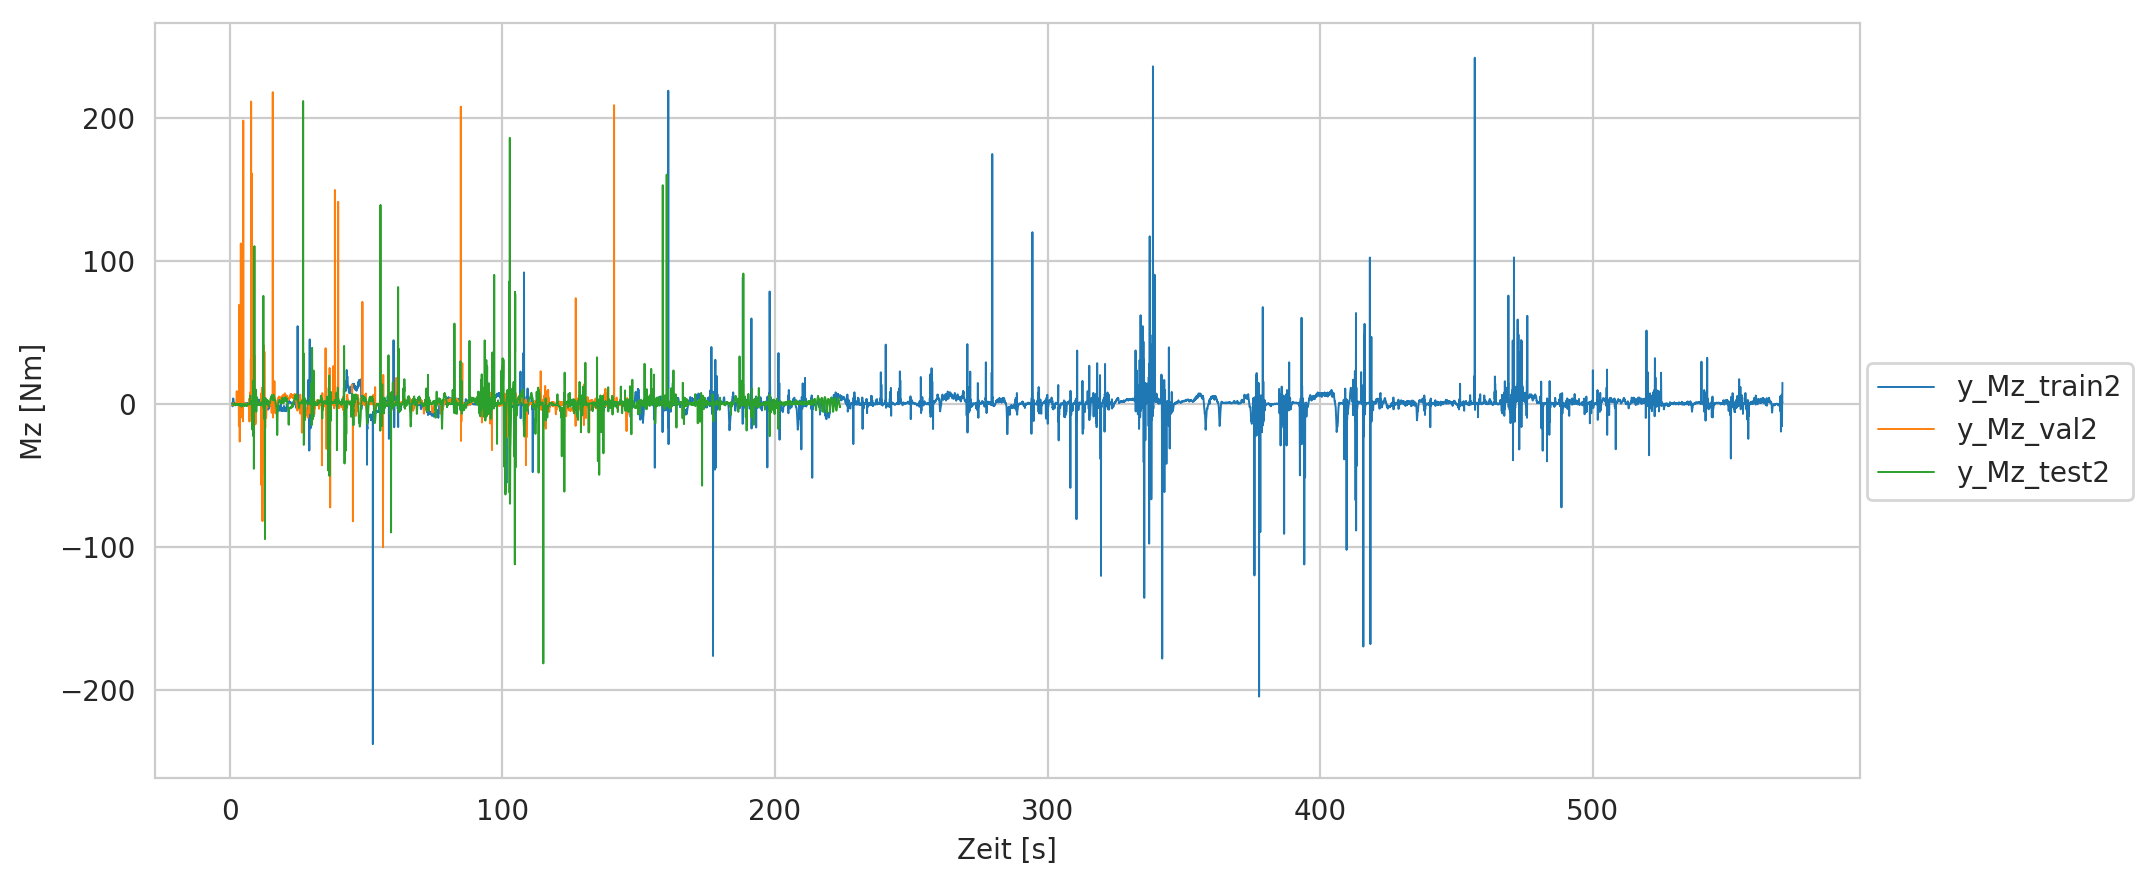

In [229]:
plt.figure(num=None, figsize=(11, 5), dpi=200, facecolor='w', edgecolor='k'),

#plt.yticks([0,1,2,3])
plt.plot(np.linspace(1,len(y_Mz_train2)*0.05-0.05,len(y_Mz_train2)), y_Mz_train2, label='y_Mz_train2',linewidth=0.7, mew=0.1)
plt.plot(np.linspace(1,len(y_Mz_val2)*0.05-0.05,len(y_Mz_val2)), y_Mz_val2, label='y_Mz_val2',linewidth=0.7, mew=0.1)
plt.plot(np.linspace(1,len(y_Mz_test2)*0.05-0.05,len(y_Mz_test2)), y_Mz_test2, label='y_Mz_test2',linewidth=0.7, mew=0.1)

plt.title('Y-Trainingsdaten der NNs zur Bestimmung der Mz-Werte')
plt.xlabel('Zeit [s]')
plt.ylabel('Mz [Nm]')

plt.legend(bbox_to_anchor=(0.64, 0.15, 0.52, 0.4), borderaxespad=0)
#plt.xlim(left=0, right=100)
#plt.ylim(bottom=-50, top=50)

plt.show()

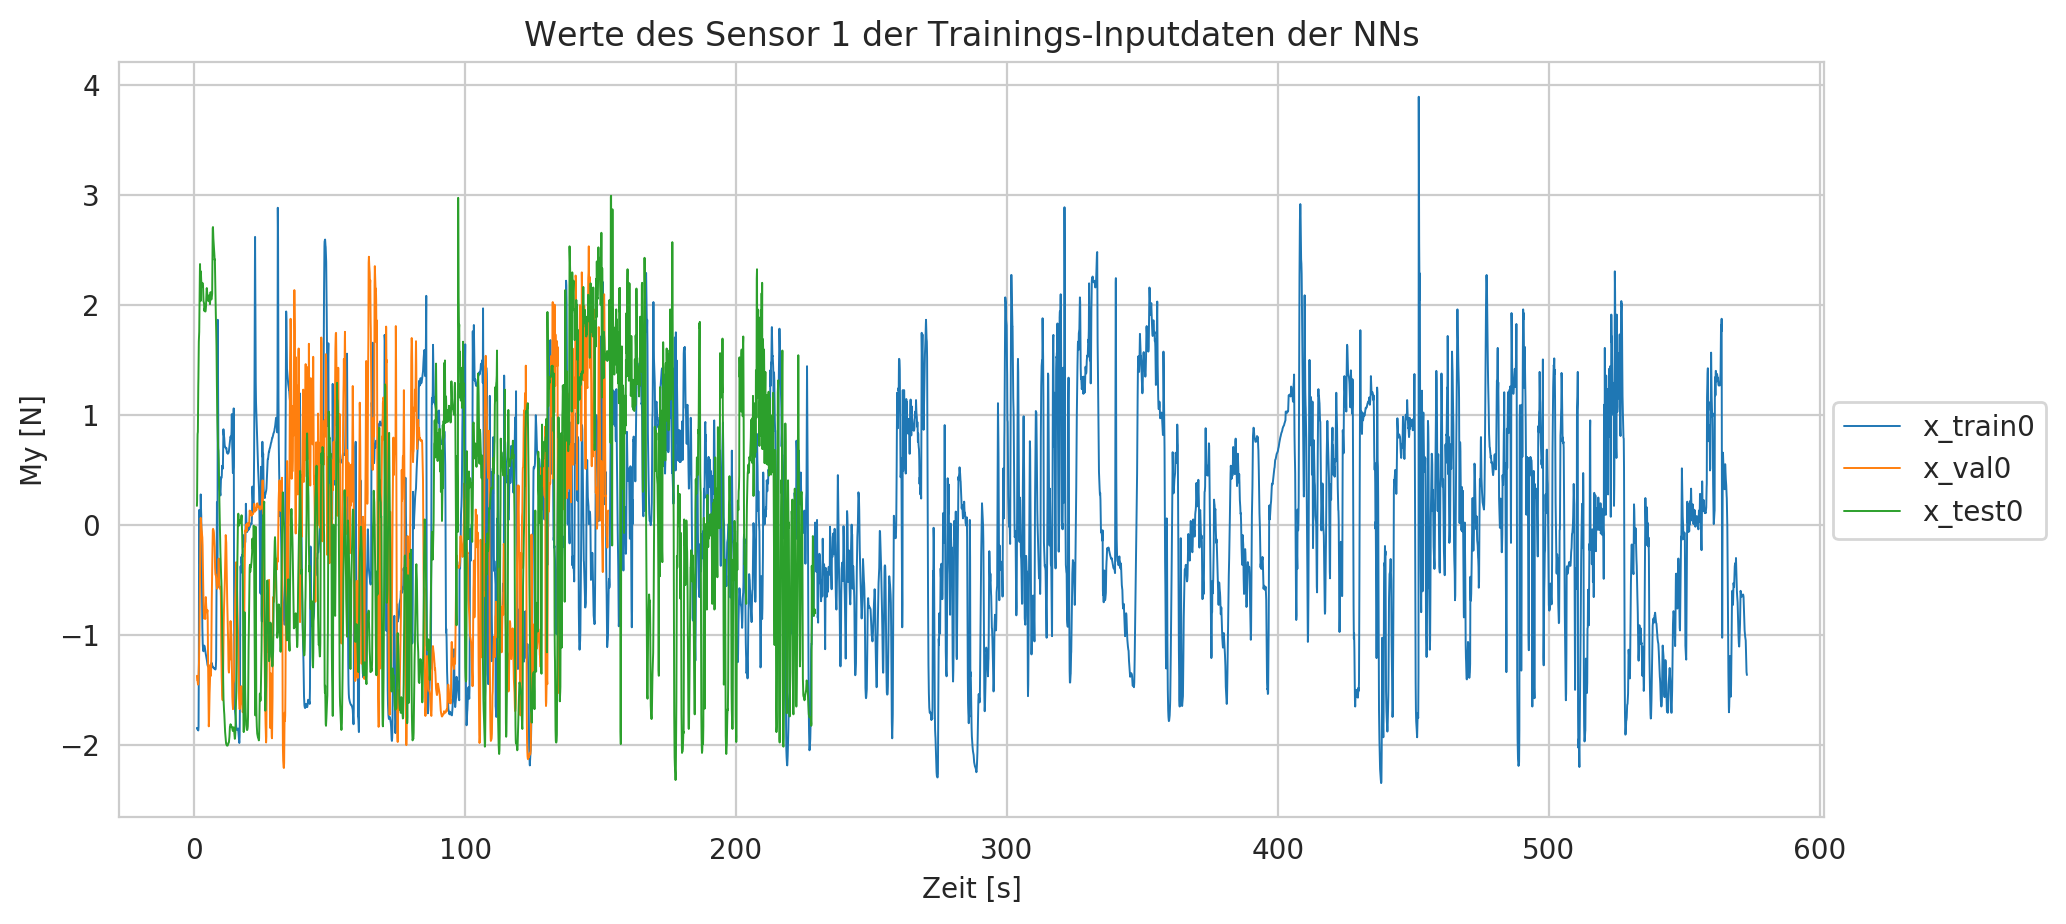

In [235]:
plt.figure(num=None, figsize=(11, 5), dpi=200, facecolor='w', edgecolor='k'),

#plt.yticks([0,1,2,3])
plt.plot(np.linspace(1,len(x_train0)*0.05-0.05,len(x_train0)), x_train0.M0A0, label='x_train0',linewidth=0.7, mew=0.1)
plt.plot(np.linspace(1,len(x_val0)*0.05-0.05,len(x_val0)), x_val0.M0A0, label='x_val0',linewidth=0.7, mew=0.1)
plt.plot(np.linspace(1,len(x_test0)*0.05-0.05,len(x_test0)), x_test0.M0A0, label='x_test0',linewidth=0.7, mew=0.1)

plt.title('Werte des Sensor 1 der Trainings-Inputdaten der NNs')
plt.xlabel('Zeit [s]')
plt.ylabel('My [N]')

plt.legend(bbox_to_anchor=(0.61, 0.15, 0.52, 0.4), borderaxespad=0)
#plt.xlim(left=0, right=100)
#plt.ylim(bottom=-50, top=50)

plt.show()

#### 60% 16% 24%

In [54]:
train_p = int(len(y_mat)*0.6)
val_p = train_p+int(len(y_mat)*0.16)
test_p = len(y_mat)

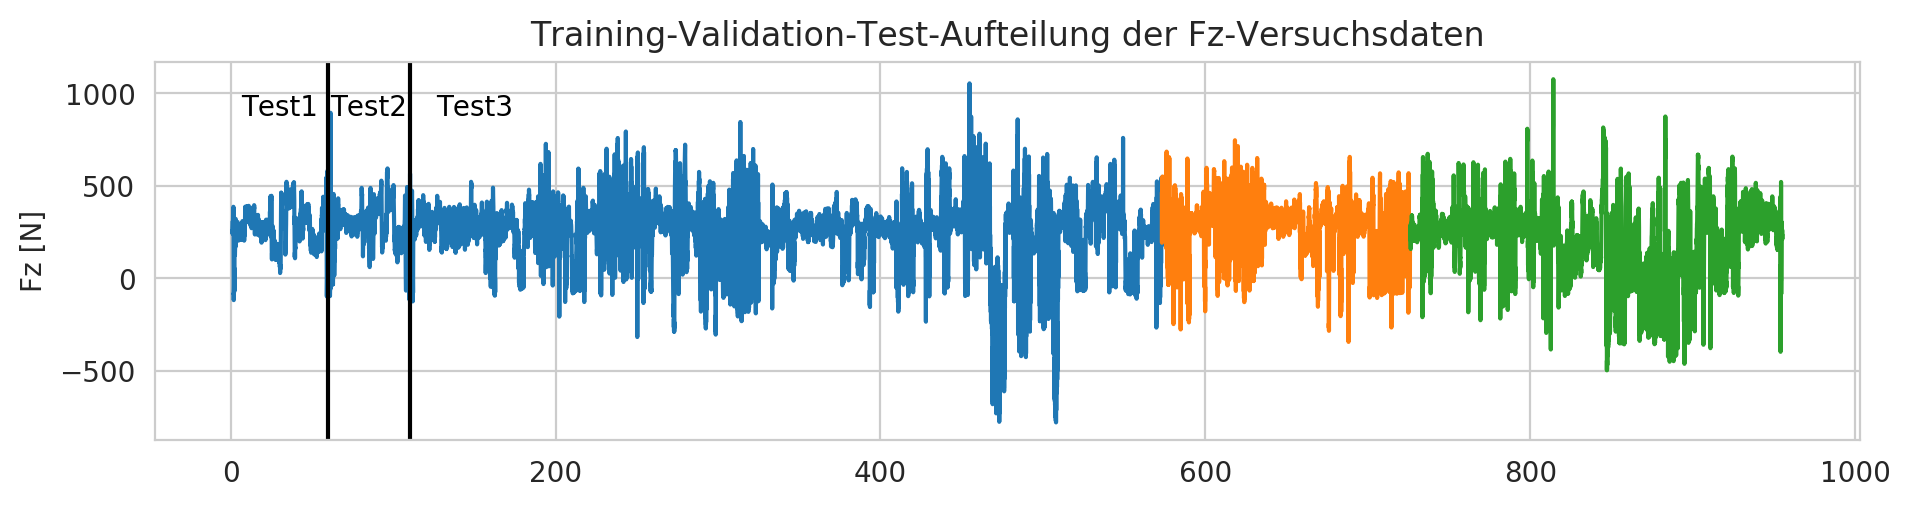

In [171]:
plt.figure(num=None, figsize=(11, 2.5), dpi=200, facecolor='w', edgecolor='k'),
coulumn_plt = 0

plt.plot(np.linspace(1,train_p*0.05-0.05,train_p) ,y_mat[:train_p,coulumn_plt], label='Trainingsdaten')
plt.plot(np.linspace((train_p+1)*0.05,val_p*0.05-0.05,(val_p-train_p)) ,y_mat[train_p:val_p,coulumn_plt], label='Validierungsdaten')
plt.plot(np.linspace((val_p+1)*0.05,test_p*0.05-0.05,(test_p-val_p)) ,y_mat[val_p:test_p,coulumn_plt], label='Testdaten')

plt.title('Training-Validation-Test-Aufteilung der Fz-Versuchsdaten')
#plt.xlabel('Zeit [s]')
plt.ylabel('Fz [N]')
plt.axvline(x=len(y_mat1)*0.05, ymin=0, ymax=1, color='k')
plt.axvline(len(y_mat2)*0.05+len(y_mat1)*0.05, ymin=0, ymax=1, color='k')

#plt.legend(bbox_to_anchor=(0.72, 0.15, 0.5, 0.4), borderaxespad=0)
#plt.xlim(left=0, right=100)
#plt.ylim(bottom=-50, top=50)

plt.text(30, 1000, 'Test1',
         horizontalalignment='center',
         verticalalignment='top',
         multialignment='center', color='k')
plt.text(85, 1000, 'Test2',
         horizontalalignment='center',
         verticalalignment='top',
         multialignment='center', color='k')
plt.text(150, 1000, 'Test3',
         horizontalalignment='center',
         verticalalignment='top',
         multialignment='center', color='k')

plt.show()



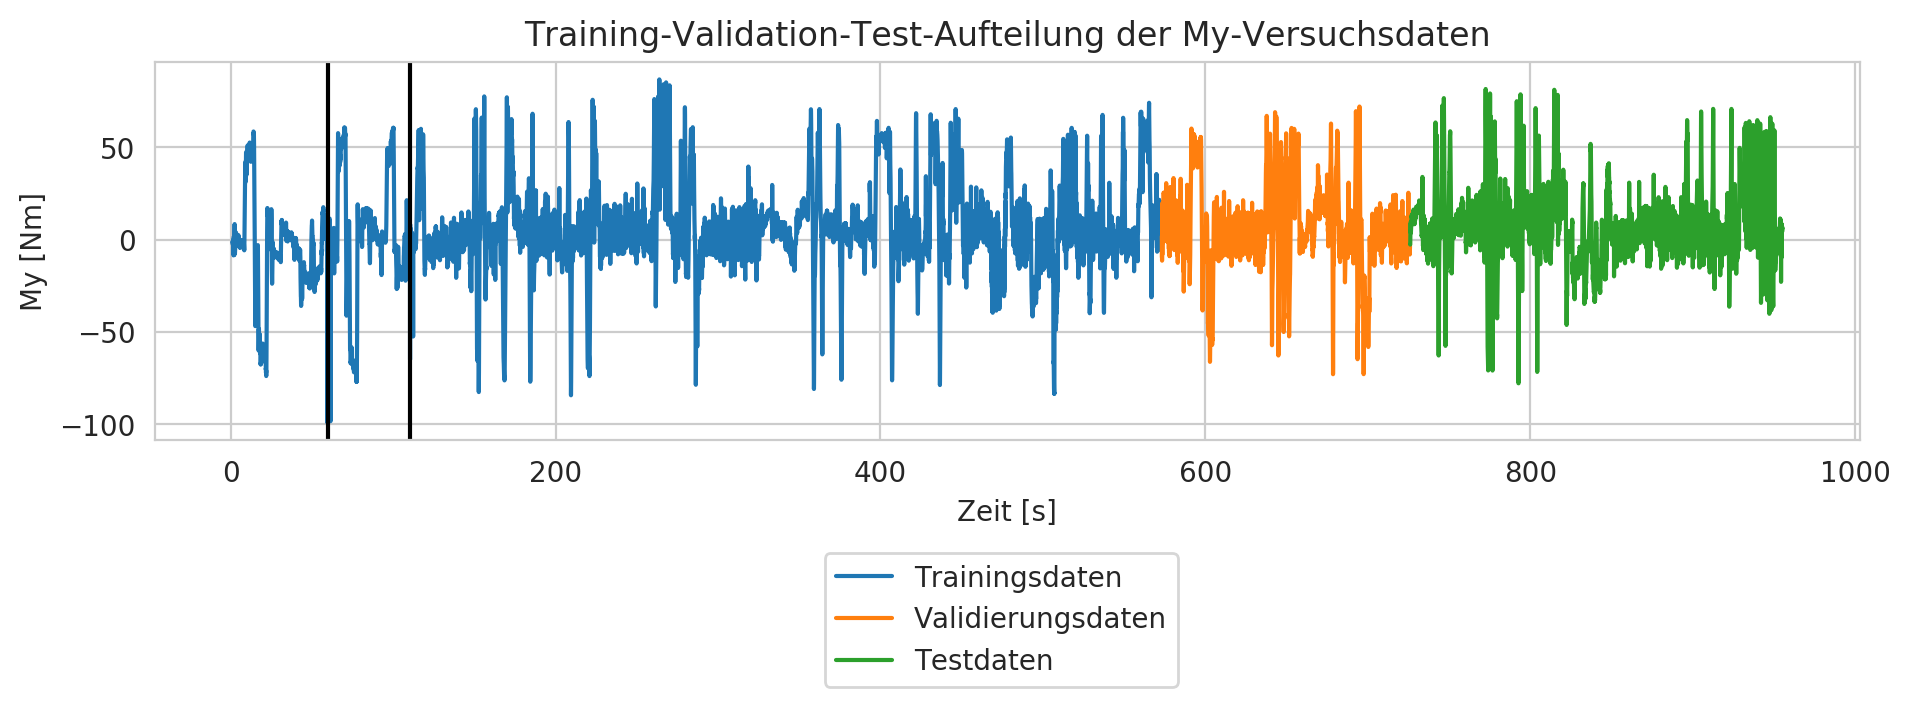

In [174]:
plt.figure(num=None, figsize=(11, 2.5), dpi=200, facecolor='w', edgecolor='k'),
coulumn_plt = 1

plt.plot(np.linspace(1,train_p*0.05-0.05,train_p) ,y_mat[:train_p,coulumn_plt], label='Trainingsdaten')
plt.plot(np.linspace((train_p+1)*0.05,val_p*0.05-0.05,(val_p-train_p)) ,y_mat[train_p:val_p,coulumn_plt], label='Validierungsdaten')
plt.plot(np.linspace((val_p+1)*0.05,test_p*0.05-0.05,(test_p-val_p)) ,y_mat[val_p:test_p,coulumn_plt], label='Testdaten')

plt.title('Training-Validation-Test-Aufteilung der My-Versuchsdaten')
plt.xlabel('Zeit [s]')
plt.ylabel('My [Nm]')
plt.axvline(x=len(y_mat1)*0.05, ymin=0, ymax=1, color='k')
plt.axvline(len(y_mat2)*0.05+len(y_mat1)*0.05, ymin=0, ymax=1, color='k')

plt.legend(bbox_to_anchor=(0.6, -0.3, 0., 0.), borderaxespad=0)
#plt.xlim(left=0, right=100)
#plt.ylim(bottom=-50, top=50)


plt.show()


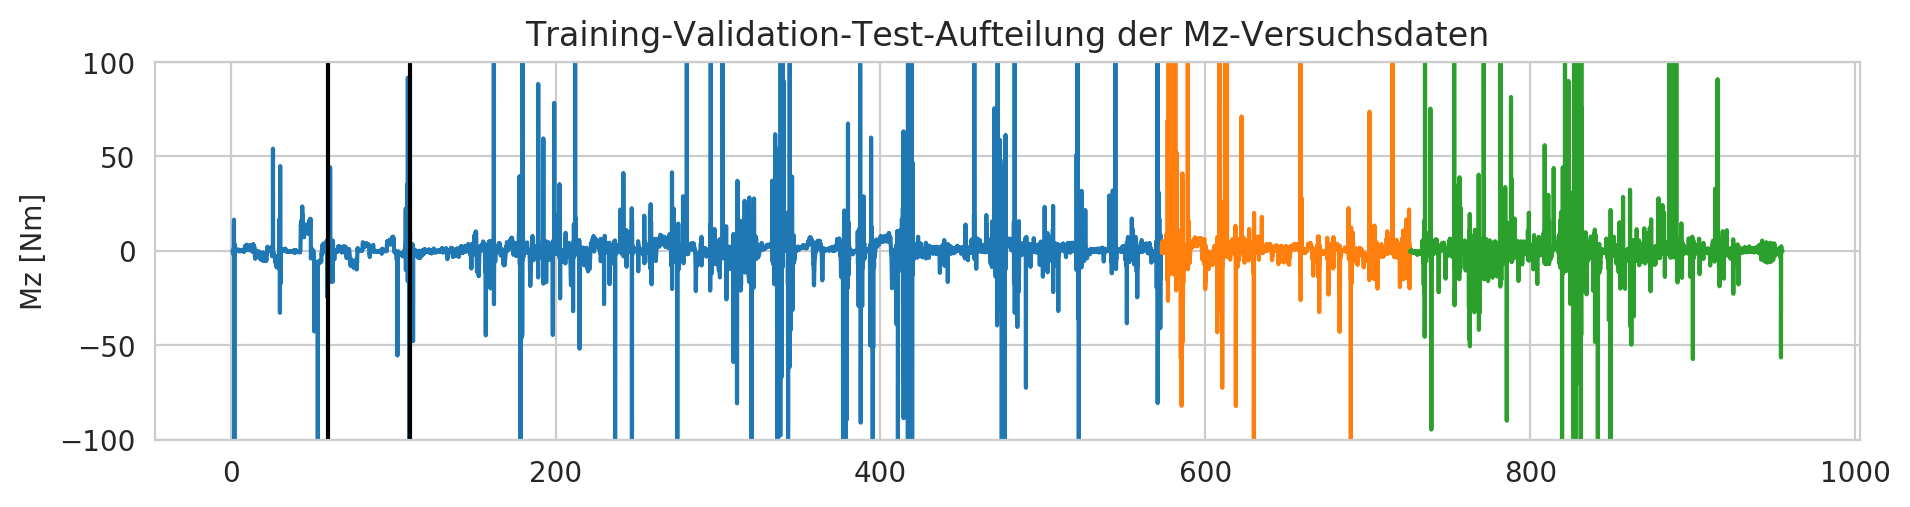

In [173]:
plt.figure(num=None, figsize=(11, 2.5), dpi=200, facecolor='w', edgecolor='k'),
coulumn_plt = 2

plt.plot(np.linspace(1,train_p*0.05-0.05,train_p) ,y_mat[:train_p,coulumn_plt], label='Trainingsdaten')
plt.plot(np.linspace((train_p+1)*0.05,val_p*0.05-0.05,(val_p-train_p)) ,y_mat[train_p:val_p,coulumn_plt], label='Validierungsdaten')
plt.plot(np.linspace((val_p+1)*0.05,test_p*0.05-0.05,(test_p-val_p)) ,y_mat[val_p:test_p,coulumn_plt], label='Testdaten')

plt.title('Training-Validation-Test-Aufteilung der Mz-Versuchsdaten')
#plt.xlabel('Zeit [s]')
plt.ylabel('Mz [Nm]')
plt.axvline(x=len(y_mat1)*0.05, ymin=0, ymax=1, color='k')
plt.axvline(len(y_mat2)*0.05+len(y_mat1)*0.05, ymin=0, ymax=1, color='k')

#plt.legend(bbox_to_anchor=(0.41, -0.3, 0., 0.), borderaxespad=0)
#plt.xlim(left=0, right=100)
plt.ylim(bottom=-100, top=100)


plt.show()



In [178]:
soctest1 = pd.read_csv('/Users/patrickcarqueville/Documents/Uni/Master/MA/SA/DataLogger/SockenVersuch/SensorSocken/SOCTEST1.txt',delimiter=',', header=0)

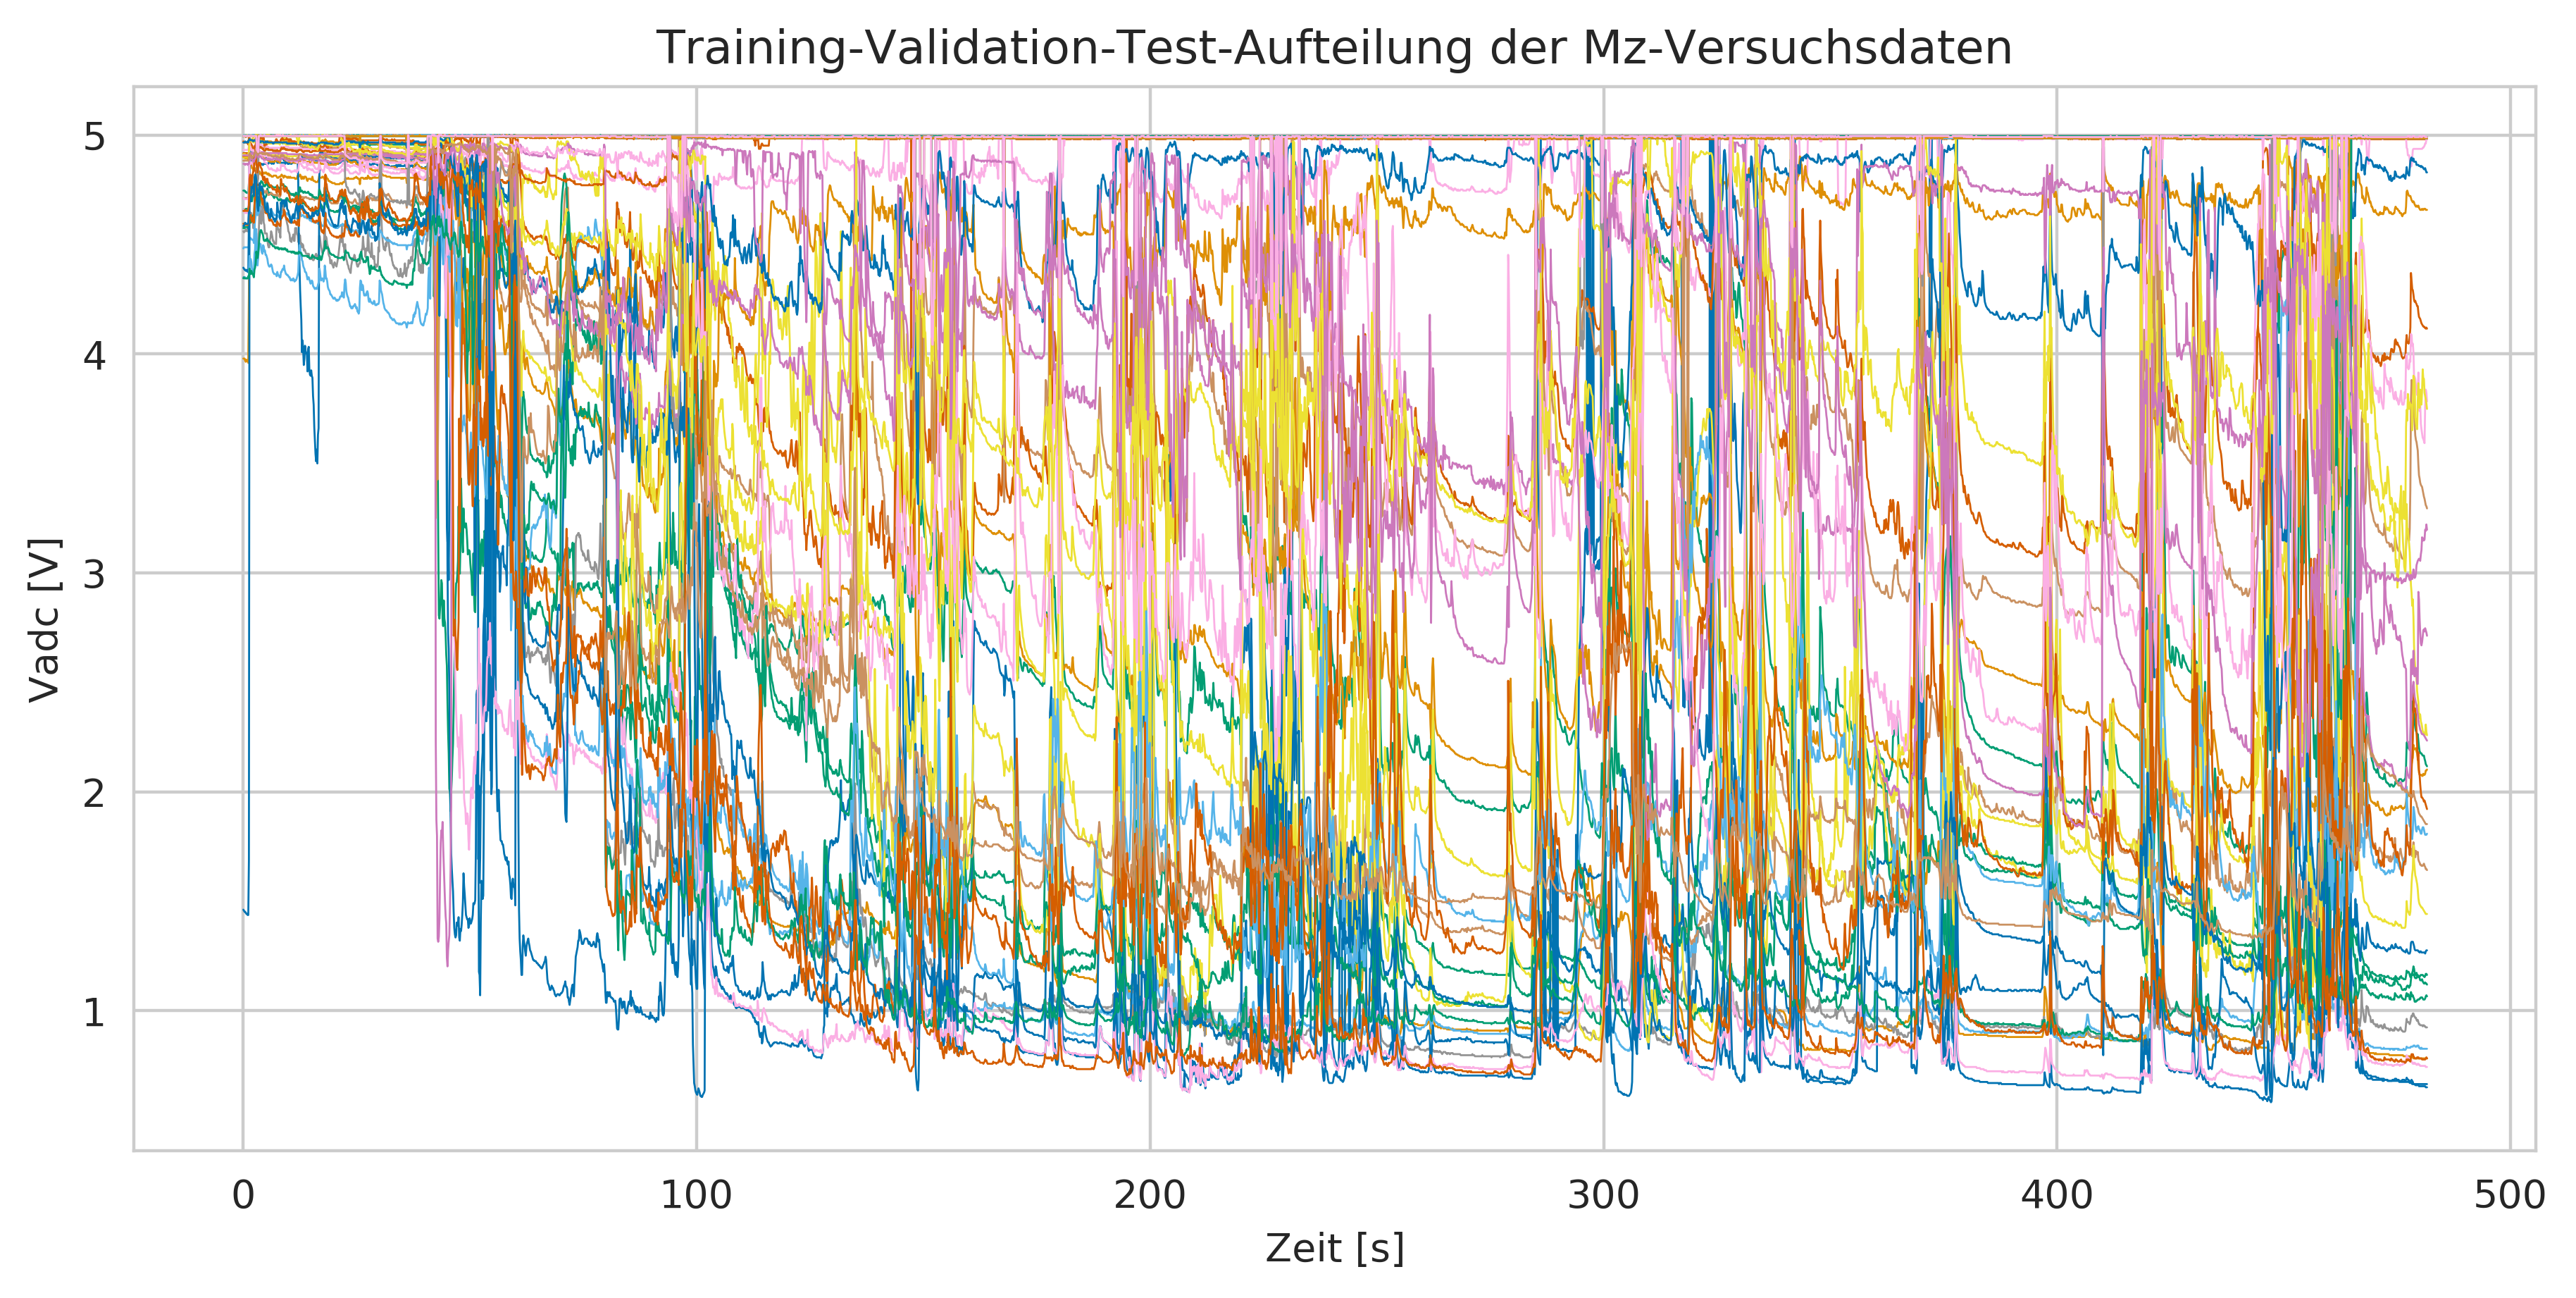

In [219]:

sns.set_palette('colorblind')
plt.figure(num=None, figsize=(11, 5), dpi=400, facecolor='w', edgecolor='k'),


#plt.plot(np.linspace(1,train_p*0.05-0.05,train_p) ,y_mat[:train_p,coulumn_plt], label='Trainingsdaten')
#plt.plot(np.linspace((train_p+1)*0.05,val_p*0.05-0.05,(val_p-train_p)) ,y_mat[train_p:val_p,coulumn_plt], label='Validierungsdaten')
#plt.plot(np.linspace((val_p+1)*0.05,test_p*0.05-0.05,(test_p-val_p)) ,y_mat[val_p:test_p,coulumn_plt], label='Testdaten')
plt.plot(np.linspace(0,3542*0.136-0.136,3542), soctest1.iloc[:,10:57]*5/1023,linewidth=0.5)

plt.title('Training-Validation-Test-Aufteilung der Mz-Versuchsdaten')
plt.xlabel('Zeit [s]')
plt.ylabel('Vadc [V]')
#plt.axvline(x=len(y_mat1)*0.05, ymin=0, ymax=1, color='k')
#plt.axvline(len(y_mat2)*0.05+len(y_mat1)*0.05, ymin=0, ymax=1, color='k')

#plt.legend(bbox_to_anchor=(0.41, -0.3, 0., 0.), borderaxespad=0)
#plt.xlim(left=0, right=100)
#plt.ylim(bottom=-100, top=100)


plt.show()





In [205]:
soctest1

10:44:18     14     15     17     23     39     56     72     90  \
0     10:44:18    167    168    171    172    174    189    205    223   
1     10:44:18    292    294    295    297    306    322    338    356   
2     10:44:18    422    424    425    428    439    455    472    489   
3     10:44:19    559    561    562    564    572    588    605    622   
4     10:44:19    689    691    692    694    705    721    738    755   
5     10:44:19    825    827    828    830    838    855    871    888   
6     10:44:19    958    960    961    963    971    988   1004   1021   
7     10:44:19   1088   1090   1092   1093   1104   1121   1137   1155   
8     10:44:19   1224   1226   1228   1229   1238   1254   1270   1288   
9     10:44:19   1355   1356   1358   1359   1371   1387   1403   1421   
10    10:44:19   1490   1492   1495   1496   1504   1520   1537   1554   
11    10:44:20   1625   1626   1628   1629   1637   1653   1670   1687   
12    10:44:20   1755   1756   1758   1760   1770   1786   1803   1820   
13    10:44:20   1891   1892   1894   1895   1903   1920   1936   1953   
14    10:44:20   2024   2025   2027   2028   2036   2053   2069   2086   
15    10:44:20   2154   2155   2157   2159   2169   2186   2202   2220   
16    10:44:20   2290   2291   2293   2294   2302   2319   2335   2353   
17    10:44:20   2420   2421   2423   2424   2436   2452   2468   2486   
18    10:44:21   2555   2557   2560   2561   2569   2585   2601   2619   
19    10:44:21   2700   2702   2704   2705   2707   2718   2735   2752   
20    10:44:21   2820   2821   2823   2824   2835   2851   2868   2885   
21    10:44:21   2956   2957   2959   2960   2968   2984   3001   3018   
22    10:44:21   3089   3090   3092   3093   3101   3118   3134   3151   
23    10:44:21   3219   3220   3222   3224   3234   3251   3267   3284   
24    10:44:21   3354   3356   3358   3359   3367   3384   3400   3418   
25    10:44:21   3485   3486   3488   3489   3501   3517   3533   3551   
26    10:44:22   3621   3622   3624   3625   3634   3650   3666   3684   
27    10:44:22   3753   3756   3758   3759   3767   3783   3800   3817   
28    10:44:22   3885   3886   3888   3890   3900   3916   3933   3950   
29    10:44:22   4021   4022   4024   4025   4033   4049   4066   4083   
...        ...    ...    ...    ...    ...    ...    ...    ...    ...   
3512  10:52:14 -23620 -23619 -23617 -23616 -23613 -23597 -23580 -23563   
3513  10:52:14 -23487 -23486 -23484 -23483 -23480 -23463 -23447 -23430   
3514  10:52:14 -23357 -23356 -23354 -23353 -23347 -23330 -23314 -23296   
3515  10:52:14 -23221 -23220 -23218 -23217 -23214 -23197 -23181 -23163   
3516  10:52:14 -23091 -23090 -23088 -23087 -23080 -23064 -23048 -23030   
3517  10:52:15 -22954 -22953 -22951 -22950 -22947 -22931 -22915 -22897   
3518  10:52:15 -22821 -22820 -22818 -22817 -22814 -22798 -22781 -22764   
3519  10:52:15 -22691 -22690 -22688 -22687 -22681 -22665 -22648 -22631   
3520  10:52:15 -22555 -22554 -22552 -22551 -22548 -22532 -22515 -22498   
3521  10:52:15 -22422 -22421 -22419 -22418 -22415 -22398 -22382 -22365   
3522  10:52:15 -22292 -22291 -22289 -22288 -22282 -22265 -22249 -22232   
3523  10:52:15 -22156 -22155 -22153 -22152 -22149 -22132 -22116 -22098   
3524  10:52:16 -22026 -22025 -22023 -22021 -22015 -21999 -21983 -21965   
3525  10:52:16 -21890 -21888 -21886 -21885 -21882 -21866 -21850 -21832   
3526  10:52:16 -21756 -21755 -21753 -21752 -21749 -21733 -21716 -21699   
3527  10:52:16 -21626 -21625 -21623 -21622 -21616 -21600 -21583 -21566   
3528  10:52:16 -21490 -21489 -21487 -21486 -21483 -21467 -21450 -21433   
3529  10:52:16 -21358 -21356 -21354 -21353 -21350 -21333 -21317 -21300   
3530  10:52:16 -21227 -21226 -21224 -21222 -21217 -21200 -21184 -21167   
3531  10:52:16 -21092 -21090 -21088 -21087 -21084 -21067 -21051 -21033   
3532  10:52:17 -20961 -20960 -20958 -20957 -20951 -20934 -20918 -20900   
3533  10:52:17 -20825 -20824 -20821 -20820 -20817 -20801 -20785 -20767   
3534  10:5

In [206]:
480/60

8.0